# Gym Equipment Classifier
When the thought of losing weight and getting in shape presents itself, a common go-to place that many think of is the local gym. However, these new gym-goers who enter the place for the first time face a very similar experience. Their untrained eyes breeze past a sea of foreign objects as they head towards the only equipment they know: dumbbells and treadmills. 
The occasional motivation to try out new machines might surface, only to be quickly brushed aside by the intimidating looks of massive bulking beasts or nonchalant individuals with their earpieces plugged in. 

If only there was an easier way to make sense of these complicated machinery and learn how to use them...

## Description
This project explores the use of transfer learning to create a classifer for images of gym equipment.

## _Before you go on.._
Why not check out the [deployment of the model](https://xfated.github.io) to see it in action :D



# Preliminary steps

## 1. Import libraries


Confirm that can connect GPU with tensorflow

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
#%matplotlib inline
import matplotlib.pyplot as ply
import pandas as pd
import os, json
from IPython.display import Image, display
import numpy as np

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
print(tf.__version__)

2.2.0


## 2. Retrieve dataset


In [0]:
!git clone https://github.com/xfated/gym_equipment_classifier.git

Cloning into 'gym_equipment_classifier'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6
Unpacking objects: 100% (6/6), done.


In [0]:
os.chdir('gym_equipment_classifier')
!unzip -qq gym_dataset.zip
!rm gym_dataset.zip
os.chdir('..')
!ls

gym_equipment_classifier  sample_data


## 3. Extract Images


a. Extract images to dataframe <br>
b. Create new column with integer values for category <br> 
c. Shuffle <br> 
d. Print details <br>

In [0]:
path = './gym_equipment_classifier/gym_dataset/'

In [0]:
img_width, img_height = 224, 224  # Based on base model

data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename,class_name))

df = pd.DataFrame(data, columns=['filename', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

#shuffle
df = df.sample(frac = 1).reset_index(drop=True)

print(df.head())
print(len(df))
print(df.dtypes)

equipment_classes = dict( enumerate(df['class_name'].cat.categories ) )
print(equipment_classes)

                                            filename    class_name  class
0  /content/gym_equipment_classifier/gym_dataset/...         smith      6
1  /content/gym_equipment_classifier/gym_dataset/...         smith      6
2  /content/gym_equipment_classifier/gym_dataset/...  cyclemachine      1
3  /content/gym_equipment_classifier/gym_dataset/...  cyclemachine      1
4  /content/gym_equipment_classifier/gym_dataset/...     treadmill      7
5116
filename        object
class_name    category
class             int8
dtype: object
{0: 'benchpress', 1: 'cyclemachine', 2: 'dumbbells', 3: 'latpulldown', 4: 'rowingmachine', 5: 'shoulderpress', 6: 'smith', 7: 'treadmill'}


## 4. Split to train and validation sets

80 - 20 split

In [0]:
#split
train_set_percentage = 0.8

df_train = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

#shuffle
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

print('Training data shape: {}'.format(df_train.shape))
print('Validation data shape: {}'.format(df_val.shape))

Training data shape: (4092, 3)
Validation data shape: (1024, 3)


# Testing with SVM 
Aim: Apply SVM classifier on the features extracted by the convolution layers


## 1. Obtain base model without prediction layer (replaced with Global Average Pooling)

In [0]:
# create base model

base_model_svm = tf.keras.applications.VGG16(weights='imagenet',
                                         include_top=False,
                                         input_shape = (224, 224, 3),
                                         pooling = 'avg')


58892288/58889256 [==============================] - 1s 0us/step


In [0]:
base_model_svm.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 2. Creating some useful functions

In [0]:
# takes image at img_path and convert to input for deep learning model
def image_to_input(img_path):
  img = image.load_img(img_path, target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x = preprocess_input(x)
  return x

# wrapper function to apply to df column (to obtain features for fitting svm)
def svm_features(img_path):
  image_input = image_to_input(img_path)
  result = base_model_svm.predict(image_input)
  return result

# single prediction on val dataset with trained svm
def single_prediction_svm(index):
  img_path = df_val['filename'][index]
  features = svm_features(img_path)
  print('Prediction: ',classifier.predict(features))
  display_img(index)

# take a random image from the dataframe and display
def display_img(index):
  display(Image(df['filename'][index]))
  print('Class: ', df['class_name'][index])

<b> Train dataset: </b> <br>
Create a column with the output features to fit SVM <br>

<b> Validation dataset: </b> <br>
Used to test accuracy afterwards

## 3. Create output features from base model prediction to be used for SVM fitting & validation

In [0]:
# retain initial df
svm_df_train = df_train
svm_df_val = df_val

# create output features
svm_df_train['output_features'] = svm_df_train['filename'].apply(lambda x: svm_features(x)[0])
svm_df_val['output_features'] = svm_df_val['filename'].apply(lambda x: svm_features(x)[0])

svm_df_train.head()

,filename,class_name,class,output_features
0,/content/gym_equipment_classifier/gym_dataset/...,latpulldown,3,"[0.0065661888, 0.46976367, 0.0, 0.29443756, 0...."
1,/content/gym_equipment_classifier/gym_dataset/...,dumbbells,2,"[6.02723, 9.473628, 4.0365953, 0.0, 6.7705164,..."
2,/content/gym_equipment_classifier/gym_dataset/...,benchpress,0,"[0.0, 5.421808, 0.026446626, 0.08106788, 1.413..."
3,/content/gym_equipment_classifier/gym_dataset/...,latpulldown,3,"[0.0, 0.5261349, 0.0, 0.0, 0.0889698, 5.070471..."
4,/content/gym_equipment_classifier/gym_dataset/...,smith,6,"[0.49093676, 2.2961912, 0.0, 0.48788616, 6.918..."


Some sample training examples

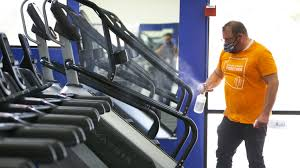

Class:  treadmill


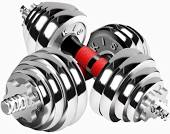

Class:  dumbbells


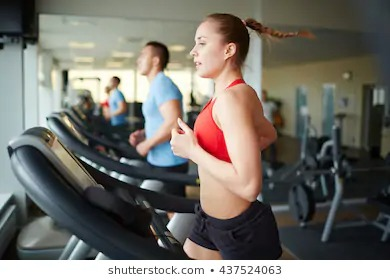

Class:  treadmill


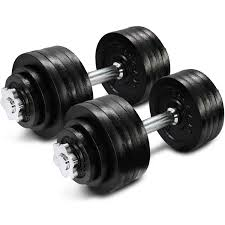

Class:  dumbbells


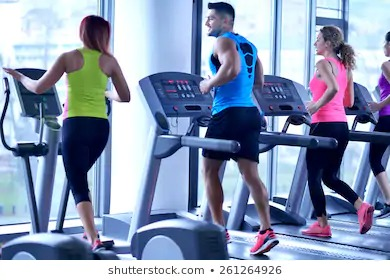

Class:  treadmill


In [0]:
display_img(np.random.randint(low=0,high=df.shape[0]))
display_img(np.random.randint(low=0,high=df.shape[0]))
display_img(np.random.randint(low=0,high=df.shape[0]))
display_img(np.random.randint(low=0,high=df.shape[0]))
display_img(np.random.randint(low=0,high=df.shape[0]))

## 4. Fit SVM!
Applying SVM on features obtained from the convolution layers in base model

In [0]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [0]:
classifier = svm.LinearSVC(max_iter = 10000)
classifier.fit(list(svm_df_train['output_features']),
               svm_df_train['class_name'])

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

## 5. Time for predictions :D

In [0]:
#Training set
svm_train_prediction = classifier.predict(list(svm_df_train['output_features']))
train_accuracy = accuracy_score(svm_train_prediction, svm_df_train['class_name'])
print('Training set accuracy: ', train_accuracy)

#Test set
svm_val_prediction = classifier.predict(list(svm_df_val['output_features']))
val_accuracy = accuracy_score(svm_val_prediction, svm_df_val['class_name'])
print('Validation set accuracy: ', val_accuracy)

Training set accuracy:  0.9938905180840665
Validation set accuracy:  0.7138671875


only about 75% :(

Prediction:  ['benchpress']


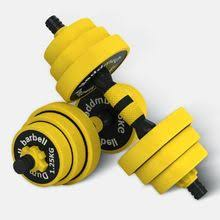

Class:  dumbbells


In [0]:
single_prediction_svm(np.random.randint(df_val.shape[0])) #passes in the index in dataframe

High training set accuracy and low validation set accuracy could imply that this overfits our training data.

# Moving on to Deep Learning Model

## 1. Create processing pipeline for train and validation datasets

Created separate functions for train and validation dataset as training dataset will have image augmentation

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224
num_classes = len(df['class_name'].unique()) 
batch_size = 32

# Include image augmentation for train dataset
@tf.function
def __parse_image_augmentation(filename, label):
  
  image_string = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image_string, channels = 3)

  #resizing
  if tf.random.uniform(()) > 0.5:
    image = tf.image.resize_with_crop_or_pad( image, img_rows, img_cols)
  
  # omit random crop as the images in some items are small (though close to middle)
  image = tf.image.resize(image, [img_rows, img_cols])
  image = tf.ensure_shape(image, shape=(img_rows, img_cols, 3))
  
  #augmentation
  image = tf.image.random_flip_left_right(image,seed=None)
  image = tf.image.random_flip_up_down(image,seed=None)

  #contrast and brightness
  if tf.random.uniform(()) > 0.4:
    image = tf.image.random_contrast(image, 0.1, 0.9, seed=None)
  if tf.random.uniform(()) > 0.4:
    image = tf.image.random_brightness( image, max_delta = 0.05, seed=None)
    image = tf.image.random_hue( image, max_delta=0.05, seed=None)
  
  #print(image.shape)
  label = tf.one_hot(label, num_classes)

  return image, label

# for validation dataset
@tf.function
def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image_string, channels = 3)
  image_resized = tf.image.resize(image, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized, shape=(img_rows, img_cols, 3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

## 2. Assemble Data pipeline using tf.data

Prepare train dataset (with image augmentation)


In [0]:
#load into tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
                                tf.cast(df_train['filename'].values, tf.string),
                                tf.cast(df_train['class'].values, tf.int32)   ))
#run the function on all members in dataset
train_dataset = train_dataset.map(__parse_image_augmentation)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())

#replicate dataset
train_dataset = train_dataset.repeat()

#split into batch
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

Prepare validation dataset (without image augmentation)


In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((
                                tf.cast(df_train['filename'].values, tf.string),
                                tf.cast(df_train['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder = True)

## 3. Create model

Use pretrained VGG16 model on imagenet dataset 


In [0]:
base_model = tf.keras.applications.VGG16(weights='imagenet',
                                         include_top = False,
                                         input_shape = (img_rows,img_cols,3)
                                         )

In [0]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Add our own prediction layer on top of features obtained from VGG16 convolutional layers

In [0]:
# add global average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# add fully connected layer
x = Dense(512, activation = 'relu')(x)

# Dropout layer
x = Dropout(0.3)(x)

# Prediction layer
predictions = Dense(num_classes, activation = 'softmax')(x)

In [0]:
model = Model(inputs = base_model.input, outputs = predictions)

Don't mess up base layer first

In [0]:
# freeze all base_model layers
#VGG
for layer in base_model.layers:
  layer.trainable = False

#InceptionV3 || MobileNetV2
#for layer in base_model.layers:
#    if 'BN' in layer.name: #batch for InceptionV3
#      print(layer.name)
#      layer.trainable = True
#    else:
#      layer.trainable = False 

In [0]:
# checking just in case
for layer in model.layers:
  print(layer.name,' Trainable = ', layer.trainable)

input_2  Trainable =  False
block1_conv1  Trainable =  False
block1_conv2  Trainable =  False
block1_pool  Trainable =  False
block2_conv1  Trainable =  False
block2_conv2  Trainable =  False
block2_pool  Trainable =  False
block3_conv1  Trainable =  False
block3_conv2  Trainable =  False
block3_conv3  Trainable =  False
block3_pool  Trainable =  False
block4_conv1  Trainable =  False
block4_conv2  Trainable =  False
block4_conv3  Trainable =  False
block4_pool  Trainable =  False
block5_conv1  Trainable =  False
block5_conv2  Trainable =  False
block5_conv3  Trainable =  False
block5_pool  Trainable =  False
global_average_pooling2d_1  Trainable =  True
dense  Trainable =  True
dropout  Trainable =  True
dense_1  Trainable =  True


In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 4. Create callback for the best model only of course

In [0]:
!mkdir checkpoints

Callback to record best model (so far)

In [0]:
checkpoint = ModelCheckpoint('./checkpoints/best_weights.hdf5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')

Change learning rate dynamically

In [0]:
reduce_LR = ReduceLROnPlateau(monitor='val_loss',
                              factor = 0.9,
                              patience = 2,
                              cooldown = 0,
                              min_lr = 0.00001)

Compile the model

In [0]:
opt = tf.keras.optimizers.Adam(lr = 0.001)

# compile model
model.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              )

## 5. Fitting the model

Obtain step size for model fitting and set number of epochs

In [0]:
train_steps = int(df_train.shape[0]/batch_size)
val_steps = int(df_val.shape[0]/batch_size)
epochs = 40

print('train steps:', train_steps)
print('val steps:', val_steps)

train steps: 127
val steps: 32


hope it goes well

In [0]:
# Train model with validation set
history = model.fit( train_dataset,
                    steps_per_epoch = train_steps,
                    epochs = epochs,
                    validation_data = valid_dataset,
                    validation_steps = val_steps,
                    callbacks = [checkpoint, reduce_LR])

Epoch 1/40
127/127 [==============================] - ETA: 0s - loss: 2.1237 - accuracy: 0.5015
Epoch 00001: val_accuracy improved from -inf to 0.71387, saving model to ./checkpoints/best_weights.hdf5
127/127 [==============================] - 24s 191ms/step - loss: 2.1237 - accuracy: 0.5015 - val_loss: 0.8965 - val_accuracy: 0.7139 - lr: 0.0010
Epoch 2/40
127/127 [==============================] - ETA: 0s - loss: 1.0363 - accuracy: 0.6484
Epoch 00002: val_accuracy improved from 0.71387 to 0.77539, saving model to ./checkpoints/best_weights.hdf5
127/127 [==============================] - 24s 190ms/step - loss: 1.0363 - accuracy: 0.6484 - val_loss: 0.6921 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 3/40
127/127 [==============================] - ETA: 0s - loss: 0.8777 - accuracy: 0.6961
Epoch 00003: val_accuracy improved from 0.77539 to 0.80273, saving model to ./checkpoints/best_weights.hdf5
127/127 [==============================] - 25s 194ms/step - loss: 0.8777 - accuracy: 0.6961 - val

For reference, the final validation accuracy obtained from here was about 96% on average for VGG16.
 (and 84% for MobileNetV2)

Take the best weights we obtained

In [0]:
model.load_weights('./checkpoints/best_weights.hdf5')

## 6. Finetuning

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Basically repeated the following block of code, unfreezing block by block to check if the validation accuracy has improved

Unfreeze blocks



In [0]:
# use iteration so i don't have to do it manually. thankfully the blocks have similar names

for i in reversed(range(5)): #5 for VGG, 16 for MobileNetV2
  print('Unfreezing block ', i+1)
  model.trainable = True

  # unfreeze blocks of convolutional layer
  set_trainable = False
  for layer in model.layers:
    #VGG
    if layer.name == 'block' + str(i+1) + '_conv1':#'block_' + str(i+1) + '_expand':  
      set_trainable=True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

  # fit unfrozen model
  history = model.fit( train_dataset,
                      steps_per_epoch = train_steps,
                      epochs = 10,
                      validation_data = valid_dataset,
                      validation_steps = val_steps,
                      callbacks = [checkpoint, reduce_LR]) 

Unfreezing block  5
Epoch 1/10
127/127 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9198
Epoch 00001: val_accuracy did not improve from 0.97852
127/127 [==============================] - 24s 188ms/step - loss: 0.2368 - accuracy: 0.9198 - val_loss: 0.0773 - val_accuracy: 0.9785 - lr: 7.2900e-04
Epoch 2/10
127/127 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.9117
Epoch 00002: val_accuracy did not improve from 0.97852
127/127 [==============================] - 24s 188ms/step - loss: 0.2516 - accuracy: 0.9117 - val_loss: 0.0826 - val_accuracy: 0.9736 - lr: 7.2900e-04
Epoch 3/10
127/127 [==============================] - ETA: 0s - loss: 0.2613 - accuracy: 0.9119
Epoch 00003: val_accuracy did not improve from 0.97852
127/127 [==============================] - 24s 185ms/step - loss: 0.2613 - accuracy: 0.9119 - val_loss: 0.0866 - val_accuracy: 0.9727 - lr: 7.2900e-04
Epoch 4/10
127/127 [==============================] - ETA: 0s - loss: 0.22

In [0]:
# load best weights
model.load_weights('./checkpoints/best_weights.hdf5')

The accuracy reached up to 99% at times, I'd say that's some pretty decent fine-tuning.

## 7. Evaluation

In [0]:
metrics = model.evaluate(valid_dataset,
                         steps = val_steps)
print("model accuracy:", metrics[1])

32/32 [==============================] - 4s 121ms/step - loss: 0.0054 - accuracy: 1.0000
model accuracy: 1.0


Wow, thats an impressive jump ahead of the SVM classifier

### Testing with some sample images

In [0]:
def model_single_prediction(img_path):
  # display the image for reference
  display(Image(img_path))

  # preprocess for model
  img = image.load_img(img_path, target_size = (img_rows, img_cols))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  # make prediction
  prediction = model.predict(x)

  # get class code based on index with highest probability
  cat_code = np.argmax(prediction)

  # map to equipment type
  print('Prediction: ', equipment_classes[cat_code])

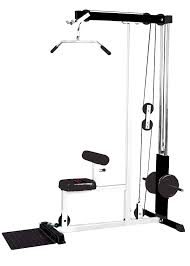

Prediction:  latpulldown


In [0]:
## select random index of image to train
index = np.random.randint(df_val.shape[0])

img_path = df['filename'][index]
## otherwise can import random online image and test

## make a prediction
model_single_prediction(img_path)

## Summary

The test images were batched downloaded from google images as well as shutter stock (which explains the watermark). And I chose 8 categories to begin with more of as a proof of concept. The collab file and web implementation can easily be scaled up to include more categories given the training examples.

One thing I noted during the self testing was that although the model validation accuracy was high at 99%, the images sourced from the internet was not representative of the kind that one would take at home or in the gym. As such, these photos might be wrongly categorised at times.

I first did transfer learning from VGG16 which managed to reach an accuracy of 99%. I managed to deploy it on the web. And it worked. But loading the model on a mobile webpage took painfully at times.

So I tried using the MobileNetV2 model as the base model which was comparatively lightweight, and reached an accuracy of 98.9%.

However, loading the page on a mobile phone still took way longer than I had hoped. Any advice on this will be appreciated!



## 9. Prepare the model for Web Format (Only run if you want to keep the model)
Saving them because well.. to not lose them 

In [0]:
## saving to HDF5 file
#model.save('keras.h5') 

Install tfjs package for conversion

In [0]:
#!pip install tensorflowjs

In [0]:
#!tensorflowjs --version

Convert model

In [0]:
#!mkdir model
#!tensorflowjs_converter --input_format keras keras.h5 model/

-.- exporting the model may append '_1' (or something similar) at the back of the layer names in the model.json file. Take note to change else will have error loading model with tensorflowjs

Zip model to download to local machine

In [0]:
#!zip -r model.zip model

Download model

Mount gdrive

In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive',force_remount=True)

Copy file to drive

In [0]:
#!cp model.zip '/content/gdrive/My Drive/'
#!ls -lt '/content/gdrive/My Drive/' 